# OVERFITTING

***Implement various strategies to mitigate overfitting using Transfer Learning in medical image***


### Loading the Images from directory

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip "/content/drive/MyDrive/pneumonia_small.zip"

In [1]:
import numpy as np
import pandas as pd
import os

In [2]:
base_dir = './pneumonia_small'

folders = ['train', 'test', 'val']
data = []

for folder in folders:
    folder_path = os.path.join(base_dir, folder)
    for label in ['NORMAL', 'PNEUMONIA']:
        label_folder = os.path.join(folder_path, label)
        for file_name in os.listdir(label_folder):
            if file_name.endswith('.jpeg') or file_name.endswith('.png') or file_name.endswith('.jpg'):
                file_path = os.path.join(label_folder, file_name)
                data.append([file_path, label.lower()])

df = pd.DataFrame(data, columns=['file_path', 'label'])

df.head(5)

,file_path,label
0,./pneumonia_small/train/NORMAL/IM-0358-0001.jpeg,normal
1,./pneumonia_small/train/NORMAL/IM-0293-0001.jpeg,normal
2,./pneumonia_small/train/NORMAL/IM-0115-0001.jpeg,normal
3,./pneumonia_small/train/NORMAL/IM-0383-0001.jpeg,normal
4,./pneumonia_small/train/NORMAL/IM-0317-0001.jpeg,normal


### Sample Data

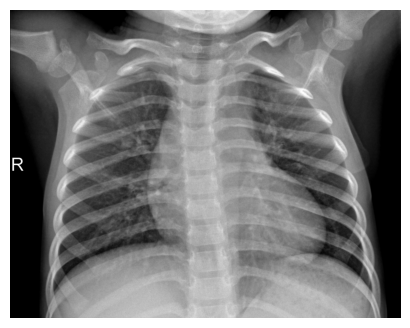

In [3]:
import matplotlib.pyplot as plt, cv2

img = cv2.imread(df['file_path'][0])

plt.figure(figsize=(6,4))
plt.imshow(img)
plt.axis("off")
plt.show()

### Label Encoding

In [4]:
df = df.sample(frac=1).reset_index(drop=True)

df['label'] = df['label'].map({'normal': 'normal', 'pneumonia': 'pneumonia'})  # Convert to strings

df.head(5)

,file_path,label
0,./pneumonia_small/train/NORMAL/IM-0278-0001.jpeg,normal
1,./pneumonia_small/train/NORMAL/IM-0280-0001.jpeg,normal
2,./pneumonia_small/test/NORMAL/IM-0023-0001.jpeg,normal
3,./pneumonia_small/train/NORMAL/IM-0345-0001.jpeg,normal
4,./pneumonia_small/test/NORMAL/IM-0061-0001.jpeg,normal


### Augmentation of Data

Regularization technique to overcome overfitting

In [5]:
train_df = df[df['file_path'].str.contains('train')]
val_df = df[df['file_path'].str.contains('val')]

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [7]:
test_datagen = ImageDataGenerator(rescale=1./255)

# AUGMENTING TRAINING IMAGES
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='file_path',
    y_col='label',
    target_size=(256, 256),
    batch_size=32,
    class_mode='binary'
)

# AUGMENTING VALIDATION IMAGES
validation_generator = test_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='file_path',
    y_col='label',
    target_size=(256, 256),
    batch_size=32,
    class_mode='binary'
)


Found 400 validated image filenames belonging to 2 classes.
Found 16 validated image filenames belonging to 2 classes.


### MobileNet Pre-Trained Model

In [8]:
from tensorflow.keras.applications import MobileNetV2

# Load the base MobileNetV2 model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

<ipython-input-8-2605638792f2>:4: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(256, 256, 3))


### Transfer Learning - Adding custom Layers

- DROPOUT: Regularization Technique to avoid overfitting by reducing over-complexity

In [9]:
from tensorflow.keras.layers import Conv2D, Dropout, Dense, Flatten

x = base_model.output

x = Conv2D(32, (1, 1), activation='relu')(x)
x = Dropout(0.25)(x)

x = Conv2D(64, (1, 1), activation='relu')(x)
x = Dropout(0.25)(x)

x = Conv2D(128, (1, 1), activation='relu')(x)
x = Dropout(0.25)(x)

x = Conv2D(256, (1, 1), activation='relu')(x)
x = Dropout(0.25)(x)

- Adding L2 (Ridge) regularization

In [10]:
from keras.regularizers import l2

x = Flatten()(x)

x = Dense(512, activation='relu', kernel_regularizer=l2(0.001))(x)  # Adding L2 regularizer

x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)

In [11]:
from keras.models import Model

model = Model(inputs=base_model.input, outputs=x)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 128, 128, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 128, 128, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 128, 128, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 128, 128, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 128, 128, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 128, 128, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 128, 128, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 128, 128, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 128, 128, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 128, 128, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 128, 128, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 129, 129, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 64, 64, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise_BN 

 Total params: 10,732,065 (40.94 MB)

 Trainable params: 8,474,081 (32.33 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

### Using Callback techniques to overcome overfitting

In [12]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

- Early Stopping

In [13]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

- Model Check Points

In [14]:
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, mode='min')

### Model Training

In [18]:
steps_per_epoch = train_generator.samples // train_generator.batch_size
validation_steps = validation_generator.samples // validation_generator.batch_size

history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10,
    callbacks=[early_stopping, checkpoint],
    # steps_per_epoch=len(train_generator),
    # validation_steps=len(validation_generator)
)

Epoch 1/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 12s 575ms/step - accuracy: 0.8598 - loss: 0.7990 - val_accuracy: 0.9375 - val_loss: 0.7682
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 20s 421ms/step - accuracy: 0.9049 - loss: 0.6502 - val_accuracy: 0.9375 - val_loss: 0.6259
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 20s 455ms/step - accuracy: 0.9106 - loss: 0.5878 - val_accuracy: 0.9375 - val_loss: 0.5284
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 19s 436ms/step - accuracy: 0.9302 - loss: 0.5202 - val_accuracy: 0.9375 - val_loss: 0.4990
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 22s 412ms/step - accuracy: 0.9395 - loss: 0.4310 - val_accuracy: 0.9375 - val_loss: 0.4156
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 11s 383ms/step - accuracy: 0.9452 - loss: 0.4534 - val_accuracy: 0.9375 - val_loss: 0.4047
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 19s 440ms/step - accuracy: 0.9385 - loss: 0.4089 - val_accuracy: 0.9375 - val_loss: 0.4035
Epoch 8/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 28s 484ms/step - accuracy: 0.9404 - loss: 0.4040 - val_accu

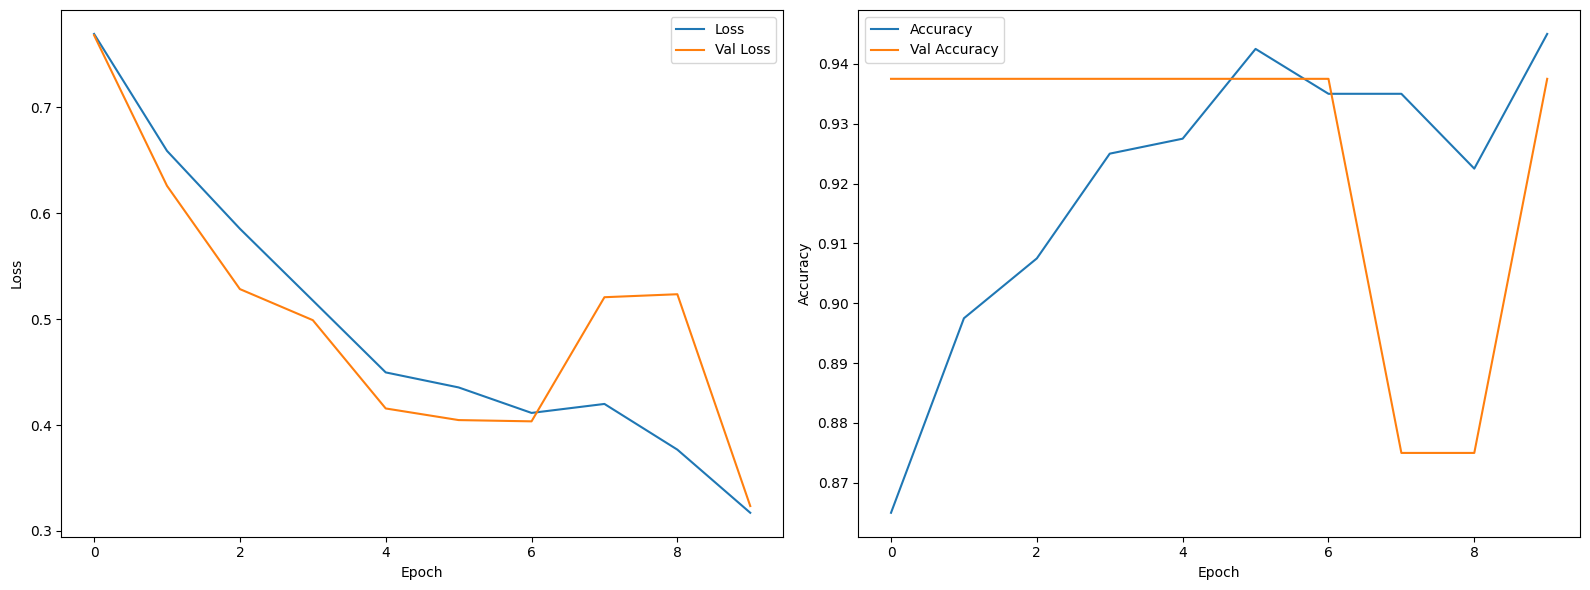

In [21]:
plt.figure(figsize=(16, 6))

# Loss subplot
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy subplot
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [23]:
print("Accuracy:", history.history['accuracy'][-1])
print("Loss:", history.history['loss'][-1])
print("Validation Accuracy:", history.history['val_accuracy'][-1])
print("Validation Loss:", history.history['val_loss'][-1])

Accuracy: 0.9449999928474426
Loss: 0.31709033250808716
Validation Accuracy: 0.9375
Validation Loss: 0.32345908880233765


<hr>